<a href="https://colab.research.google.com/github/Chrisini/DecentNet/blob/master/weak_vessel_map.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 𝕎𝕖𝕒𝕜 𝕧𝕖𝕤𝕤𝕖𝕝 𝕞𝕒𝕤𝕜 𝕘𝕖𝕟𝕖𝕣𝕒𝕥𝕚𝕠𝕟

* In order to understand our concept clusters and neural network results, we want to get vessel information.

# Import

In [ ]:
import os
import glob

from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.utils.data import DataLoader, Dataset
# import torch.backends.cudnn as cudnn
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms.functional as TF
from torchvision.transforms import Compose, Resize, Normalize, ToTensor, ToPILImage

if True:
  !pip install bunch
  from bunch import Bunch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for bunch: filename=bunch-1.0.1-py3-none-any.whl size=7095 sha256=b5b8cbcaea7be43a3df0404828d261d6a9495183f9234ec7a8e4e2c723fd2bde
  Stored in directory: /root/.cache/pip/wheels/81/03/84/acbaef8b5bc2ecc1bf944c572037d0fb232a19b19a96579f97
Successfully built bunch


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

if True:
    train_path =     r"/content/drive/MyDrive/decentnet/data/images/train/AMD"
else:
    train_path =     r"/content/drive/MyDrive/decentnet/data/images/train/nonAMD"

ckpt_vessel_path =   r"/content/drive/MyDrive/decentnet/ckpt/vessel_unet_w_liu"

vessel_path =        r"/content/drive/MyDrive/decentnet/data/masks/Vessel_Masks" # results
vessel_path_thresh = r"/content/drive/MyDrive/decentnet/data/masks/Vessel_Masks_Thresholded" # results


Mounted at /content/drive


# FR Unet

This code is stolen and adapted from: https://github.com/lseventeen/FR-UNet
Liu, Wentao, et al. "Full-resolution network and dual-threshold iteration for retinal vessel and coronary angiograph segmentation." IEEE Journal of Biomedical and Health Informatics 26.9 (2022): 4623-4634.

In [ ]:
class vessel_dataset(Dataset):
    def __init__(self, path):

        self.data_path = path
        self.data_file = os.listdir(self.data_path)
        
        self.transforms = Compose([
            Resize((592, 592)),
            ToTensor(),
            # Normalize((0.7, ), (0.7, )) # grayscale
        ])

    def __getitem__(self, idx):
        path = os.path.join(self.data_path, self.data_file[idx])
        
        img = Image.open(path)# .convert("L")
        red, img, blue = img.split()
        size = img.size
        img = self.transforms(img)
        return img, self.data_file[idx], size

    def __len__(self):
        return len(self.data_file)

In [ ]:
class conv(nn.Module):
    def __init__(self, in_c, out_c, dp=0):
        super(conv, self).__init__()
        self.in_c = in_c
        self.out_c = out_c
        self.conv = nn.Sequential(
            nn.Conv2d(out_c, out_c, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_c),
            nn.Dropout2d(dp),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Conv2d(out_c, out_c, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_c),
            nn.Dropout2d(dp),
            nn.LeakyReLU(0.1, inplace=True))
        self.relu = nn.LeakyReLU(0.1, inplace=True)

    def forward(self, x):
        res = x
        x = self.conv(x)
        out = x + res
        out = self.relu(out)
        return x


class feature_fuse(nn.Module):
    def __init__(self, in_c, out_c):
        super(feature_fuse, self).__init__()
        self.conv11 = nn.Conv2d(
            in_c, out_c, kernel_size=1, padding=0, bias=False)
        self.conv33 = nn.Conv2d(
            in_c, out_c, kernel_size=3, padding=1, bias=False)
        self.conv33_di = nn.Conv2d(
            in_c, out_c, kernel_size=3, padding=2, bias=False, dilation=2)
        self.norm = nn.BatchNorm2d(out_c)

    def forward(self, x):
        x1 = self.conv11(x)
        x2 = self.conv33(x)
        x3 = self.conv33_di(x)
        out = self.norm(x1+x2+x3)
        return out


class up(nn.Module):
    def __init__(self, in_c, out_c, dp=0):
        super(up, self).__init__()
        self.up = nn.Sequential(
            nn.ConvTranspose2d(in_c, out_c, kernel_size=2,
                               padding=0, stride=2, bias=False),
            nn.BatchNorm2d(out_c),
            nn.LeakyReLU(0.1, inplace=False))

    def forward(self, x):
        x = self.up(x)
        return x


class down(nn.Module):
    def __init__(self, in_c, out_c, dp=0):
        super(down, self).__init__()
        self.down = nn.Sequential(
            nn.Conv2d(in_c, out_c, kernel_size=2,
                      padding=0, stride=2, bias=False),
            nn.BatchNorm2d(out_c),
            nn.LeakyReLU(0.1, inplace=True))

    def forward(self, x):
        x = self.down(x)
        return x


class block(nn.Module):
    def __init__(self, in_c, out_c,  dp=0, is_up=False, is_down=False, fuse=False):
        super(block, self).__init__()
        self.in_c = in_c
        self.out_c = out_c
        if fuse == True:
            self.fuse = feature_fuse(in_c, out_c)
        else:
            self.fuse = nn.Conv2d(in_c, out_c, kernel_size=1, stride=1)

        self.is_up = is_up
        self.is_down = is_down
        self.conv = conv(out_c, out_c, dp=dp)
        if self.is_up == True:
            self.up = up(out_c, out_c//2)
        if self.is_down == True:
            self.down = down(out_c, out_c*2)

    def forward(self,  x):
        if self.in_c != self.out_c:
            x = self.fuse(x)
        x = self.conv(x)
        if self.is_up == False and self.is_down == False:
            return x
        elif self.is_up == True and self.is_down == False:
            x_up = self.up(x)
            return x, x_up
        elif self.is_up == False and self.is_down == True:
            x_down = self.down(x)
            return x, x_down
        else:
            x_up = self.up(x)
            x_down = self.down(x)
            return x, x_up, x_down


class FR_UNet(nn.Module):
    def __init__(self,  num_classes=1, num_channels=1, feature_scale=2,  dropout=0.2, fuse=True, out_ave=True):
        super(FR_UNet, self).__init__()
        self.out_ave = out_ave
        filters = [64, 128, 256, 512, 1024]
        filters = [int(x / feature_scale) for x in filters]
        self.block1_3 = block(
            num_channels, filters[0],  dp=dropout, is_up=False, is_down=True, fuse=fuse)
        self.block1_2 = block(
            filters[0], filters[0],  dp=dropout, is_up=False, is_down=True, fuse=fuse)
        self.block1_1 = block(
            filters[0]*2, filters[0],  dp=dropout, is_up=False, is_down=True, fuse=fuse)
        self.block10 = block(
            filters[0]*2, filters[0],  dp=dropout, is_up=False, is_down=True, fuse=fuse)
        self.block11 = block(
            filters[0]*2, filters[0],  dp=dropout, is_up=False, is_down=True, fuse=fuse)
        self.block12 = block(
            filters[0]*2, filters[0],  dp=dropout, is_up=False, is_down=False, fuse=fuse)
        self.block13 = block(
            filters[0]*2, filters[0],  dp=dropout, is_up=False, is_down=False, fuse=fuse)
        self.block2_2 = block(
            filters[1], filters[1],  dp=dropout, is_up=True, is_down=True, fuse=fuse)
        self.block2_1 = block(
            filters[1]*2, filters[1],  dp=dropout, is_up=True, is_down=True, fuse=fuse)
        self.block20 = block(
            filters[1]*3, filters[1],  dp=dropout, is_up=True, is_down=True, fuse=fuse)
        self.block21 = block(
            filters[1]*3, filters[1],  dp=dropout, is_up=True, is_down=False, fuse=fuse)
        self.block22 = block(
            filters[1]*3, filters[1],  dp=dropout, is_up=True, is_down=False, fuse=fuse)
        self.block3_1 = block(
            filters[2], filters[2],  dp=dropout, is_up=True, is_down=True, fuse=fuse)
        self.block30 = block(
            filters[2]*2, filters[2],  dp=dropout, is_up=True, is_down=False, fuse=fuse)
        self.block31 = block(
            filters[2]*3, filters[2],  dp=dropout, is_up=True, is_down=False, fuse=fuse)
        self.block40 = block(filters[3], filters[3],
                             dp=dropout, is_up=True, is_down=False, fuse=fuse)
        self.final1 = nn.Conv2d(
            filters[0], num_classes, kernel_size=1, padding=0, bias=True)
        self.final2 = nn.Conv2d(
            filters[0], num_classes, kernel_size=1, padding=0, bias=True)
        self.final3 = nn.Conv2d(
            filters[0], num_classes, kernel_size=1, padding=0, bias=True)
        self.final4 = nn.Conv2d(
            filters[0], num_classes, kernel_size=1, padding=0, bias=True)
        self.final5 = nn.Conv2d(
            filters[0], num_classes, kernel_size=1, padding=0, bias=True)
        self.fuse = nn.Conv2d(
            5, num_classes, kernel_size=1, padding=0, bias=True)
        # self.apply(InitWeights_He)

    def forward(self, x):
        x1_3, x_down1_3 = self.block1_3(x)
        x1_2, x_down1_2 = self.block1_2(x1_3)
        x2_2, x_up2_2, x_down2_2 = self.block2_2(x_down1_3)
        x1_1, x_down1_1 = self.block1_1(torch.cat([x1_2, x_up2_2], dim=1))
        x2_1, x_up2_1, x_down2_1 = self.block2_1(
            torch.cat([x_down1_2, x2_2], dim=1))
        x3_1, x_up3_1, x_down3_1 = self.block3_1(x_down2_2)
        x10, x_down10 = self.block10(torch.cat([x1_1, x_up2_1], dim=1))
        x20, x_up20, x_down20 = self.block20(
            torch.cat([x_down1_1, x2_1, x_up3_1], dim=1))
        x30, x_up30 = self.block30(torch.cat([x_down2_1, x3_1], dim=1))
        _, x_up40 = self.block40(x_down3_1)
        x11, x_down11 = self.block11(torch.cat([x10, x_up20], dim=1))
        x21, x_up21 = self.block21(torch.cat([x_down10, x20, x_up30], dim=1))
        _, x_up31 = self.block31(torch.cat([x_down20, x30, x_up40], dim=1))
        x12 = self.block12(torch.cat([x11, x_up21], dim=1))
        _, x_up22 = self.block22(torch.cat([x_down11, x21, x_up31], dim=1))
        x13 = self.block13(torch.cat([x12, x_up22], dim=1))
        if self.out_ave == True:
            output = (self.final1(x1_1)+self.final2(x10) +
                      self.final3(x11)+self.final4(x12)+self.final5(x13))/5
        else:
            output = self.final5(x13)




        return output

In [ ]:
import PIL.ImageOps   
class Tester():
    def __init__(self, model, checkpoint, test_loader, dataset_path):

        # test loader has to have batch size = 1

        self.test_loader = test_loader
        self.model = model

        for key in list(checkpoint['state_dict'].keys()):
            checkpoint['state_dict'][key.replace('module.', '')] = checkpoint['state_dict'].pop(key)

        self.model.load_state_dict(checkpoint['state_dict'])

    def test(self):
        
        self.model.eval()
        with torch.no_grad():
            for _, (img, image_path, size) in enumerate(self.test_loader):

                cur_img_name = os.path.splitext(os.path.basename(os.path.normpath(image_path[0])))[0]

                pred = self.model(img)

                predict = torch.sigmoid(pred).cpu().detach().numpy()

                p = predict.transpose(2,3,1,0).squeeze()
                im1 = Image.fromarray(np.uint8(p*255))
                im1 = PIL.ImageOps.invert(im1)
                im1 = im1.resize(size)
                im1 = im1.save(os.path.join( vessel_path, f"{cur_img_name}.png" )) # _pre_orig_{i}

                predict_b = np.where(predict >= 0.15, 1, 0) # first value is the threshold
                pb = predict_b.transpose(2,3,1,0).squeeze()
                im2 = Image.fromarray(np.uint8(pb*255))
                im2 = PIL.ImageOps.invert(im2)
                im2 = im2.resize(size)
                im2 = im2.save(os.path.join( vessel_path_thresh, f"{cur_img_name}.png" ))


# Main

In [ ]:
data_path = train_path
weight_path = os.path.join(ckpt_vessel_path, "drive-epoch40.pth")

result_path = vessel_path

checkpoint = torch.load(weight_path, map_location=torch.device("cpu"))

test_dataset = vessel_dataset(data_path)
test_loader = DataLoader(test_dataset, 1,
                          shuffle=False,  num_workers=0, pin_memory=True)
model = FR_UNet(num_classes=2, num_channels=1, feature_scale=2,  dropout=0.2, fuse=True, out_ave=True)
test = Tester(model, checkpoint, test_loader, data_path)
test.test()


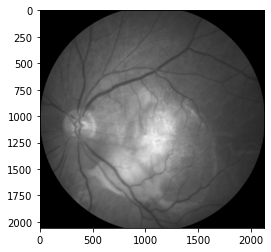

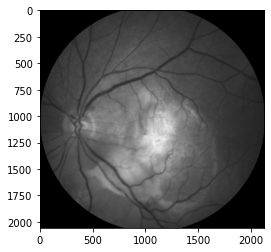

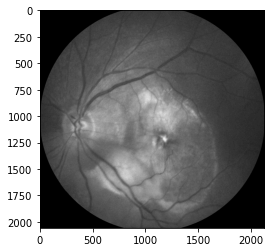

In [ ]:
data_file = os.listdir(train_path)[5]
path = os.path.join(train_path, data_file)

img = Image.open(path) # .convert("L")

red, green, blue = img.split()

t = ToTensor()
a = Normalize((0.7, ), (0.7, ))
p = ToPILImage()
 
plt.figure()
plt.imshow(p((t(img.convert('L')))), cmap="gray")
plt.figure()
plt.imshow(p((t(green))), cmap="gray")
plt.figure()
plt.imshow(p((t(blue))), cmap="gray")
